In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import matplotlib.pylab as pylab
import matplotlib as mpl
# functions to get LP from cosmology
import linear_point as lp
# doing cosmological calculations from parameters
import camb
# for getting LP with interp
from scipy.interpolate import CubicSpline

%matplotlib inline

In [2]:
# for plots
sns.set_style("ticks",
             rc = {'axes.grid' : False,
                  'grid.linestyle' : 'dashed',
                  "xtick.direction": "in","ytick.direction": "in"})

sns.set_context('paper', font_scale=1.8)
pylab.rcParams['xtick.major.pad']='6'
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

sns.set_palette("Set1")

In [3]:
# creating instance of CAMBparams object
pars = camb.CAMBparams()
# krange
kmin = 0.001
kmax = 10.

In [4]:
#pars.set_accuracy(AccuracyBoost=1.5);

In [5]:
# fiducial TT,TE,EE + lowP
ombh2_fid=0.02225
omch2_fid=0.1198
theta_fid = 1.04077/100
#h_fid = 0.6790
h_fid = 0.6727
tau_fid = 0.079
ns_fid=0.9645
As_fid=2.207e-9
# sigmas
ombh2_sig = 0.00016
omch2_sig = 0.0015
ns_sig = 0.0049

In [6]:
def get_results(pars, z=0, ombh2 = ombh2_fid, omch2 = omch2_fid,
                h = h_fid, tau = tau_fid, As = As_fid, ns = ns_fid, kmax=kmax):
    pars.set_cosmology(ombh2=ombh2,
                       omch2 =omch2,
                       H0=100*h,
                       tau=tau)
    pars.InitPower.set_params(ns=ns,
                              As=As)
    pars.set_matter_power(
        redshifts=[z], kmax=kmax, nonlinear=False, k_per_logint=0)
    return camb.get_results(pars)

def get_lp(results, rmin=115., rmax=160., rsamples=80, khmin = kmin, khmax=kmax):
    dip, peak = get_dip_peak(results, rmin, rmax, rsamples, khmin, khmax)
    return (dip+peak)/2

def get_rd(results):
    return results.get_derived_params()['rdrag']

def get_lp_rd_ratio(results):
    lp = get_lp(results)
    rd = get_rd(results)
    return lp/rd

# I've found that the xi_r is misbehaving in some ranges of r values, while xi is not. So I'll rewrite the root-finding to use use the interpolated xi to get the roots.

def get_dip_peak(results, rmin=115., rmax=160., rsamples=80, khmin = kmin, khmax=kmax):
    """Returns dip, peak by interpolating xi(r) over specified range"""
    r_list, xi_list = xi(results, rmin, rmax, rsamples, khmin, khmax)
    xi_interp = CubicSpline(r_list, xi_list, extrapolate=False)
    roots = xi_interp.derivative().roots(extrapolate=False)
    return roots[0], roots[1]

def xi(results, rmin=115., rmax=160., rsamples=30, khmin = kmin, khmax=kmax):
    """Returns xi(r) for r varying between rmin, rmax in rsamples steps"""

    # get interpolate xi_list
    r_list = np.linspace(rmin, rmax, rsamples)
    pk = lp.get_pk_func(results, khmin, khmax, k_hunit=False)
    xi_list = [lp.xi(r, pk) for r in r_list]
    return r_list, xi_list

In [7]:
# fiducial
results = get_results(pars)
lp_fid = get_lp(results)
rd_fid = get_rd(results)
print("lp_fid:{:.2f} , rd_fid:{:.2f}".format(lp_fid, rd_fid))

lp_fid:138.24 , rd_fid:147.28


In [23]:
# for parameter exploration
steps = 50
sigma_range = 10
# getting values
ombh2_vals = np.linspace(ombh2_fid - sigma_range*ombh2_sig,
                         ombh2_fid + sigma_range*ombh2_sig, steps)

omch2_vals = np.linspace(omch2_fid - sigma_range*omch2_sig,
                         omch2_fid + sigma_range*omch2_sig, steps)

ns_vals = np.linspace(ns_fid - sigma_range*ns_sig,
                         ns_fid + sigma_range*ns_sig, steps)

In [24]:
# getting results
#ombh2
df_ombh2 = pd.DataFrame(columns=['ombh2','lp','rd'])

for i, ombh2 in enumerate(ombh2_vals):
    results = get_results(pars, ombh2 = ombh2)
    df_ombh2.loc[i] = [ombh2, get_lp(results), get_rd(results)]
    
print("Done with ombh2")
#ombh2
df_omch2 = pd.DataFrame(columns=['omch2','lp','rd'])

for i, omch2 in enumerate(omch2_vals):
    results = get_results(pars, omch2 = omch2)
    df_omch2.loc[i] = [omch2, get_lp(results), get_rd(results)]

print("Done with omch2")
#ombh2
df_ns = pd.DataFrame(columns=['ns','lp','rd'])

for i, ns in enumerate(ns_vals):
    results = get_results(pars, ns = ns)
    try:
        df_ns.loc[i] = [ns, get_lp(results), get_rd(results)]
    except:
        print("Broke when ns={}".format(ns))
        df_ns.loc[i] = np.nan
    
print("Done with ns")

Done with ombh2
Done with omch2
Done with ns


## Plotting r/rfid

In [8]:
df_ombh2 = pd.read_pickle('./output/lp_rd/df_ombh2_accuracy150.pkl')
df_omch2 = pd.read_pickle('./output/lp_rd/df_omch2_accuracy150.pkl')
df_ns = pd.read_pickle('./output/lp_rd/df_ns_accuracy150.pkl')

In [9]:
dfs = [df_ombh2, df_omch2, df_ns]
# outlier and nan exclusion (the rootfinding is misfiring very rarely
# should look into that when there is time
z_threshold = 3 #how many sigmas to qualify as an outlier
for i, df in enumerate(dfs):
    z = np.abs(df - df.mean())/df.std() # get z for every entry
    print("Dropping") if (z > z_threshold).any().any() else print("Not Dropping")
    df = df.loc[~(z > z_threshold).any(axis=1)] #drops rows that have outliers
    df = df.dropna() #drop nans
    dfs[i] = df

Not Dropping
Not Dropping
Not Dropping


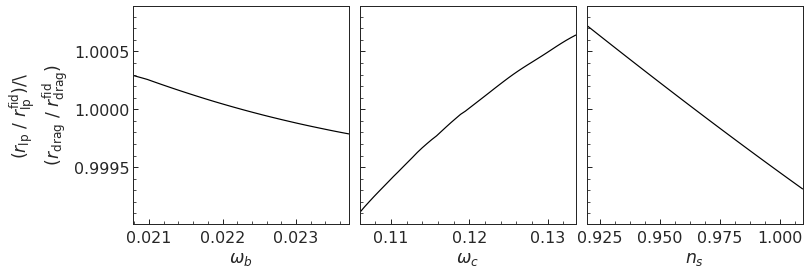

In [11]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(12,4), sharey=True)
axes = [ax1, ax2, ax3]
factor = rd_fid/lp_fid
ax_labels = [   r'$\omega_b$',
                r'$\omega_c$',
                r'$n_s$']
# plot
for ax, df in zip(axes,dfs):
    data = (factor*df.loc[:,'lp']/df.loc[:,'rd']).to_frame()
    data.index = df.iloc[:,0]
    data = data.rolling(5,win_type='gaussian', center=True).mean(std=3)
    data.plot(ax=ax, legend=False, color='k')
    ax.set_xlabel(df.columns[0])
    ax.set_xlim(data.dropna().index.min(),data.dropna().index.max())
    
# label
for i in range(len(axes)):
    axes[i].set_xlabel(ax_labels[i])

# adjustments


ax1.set_ylabel(r'$(r_{\rm lp}$ / $r^{\rm fid}_{\rm lp})$/\
$\,(r_{\rm drag}$ / $r^{\rm fid}_{\rm drag})$')
ax1.set_ylim(1-0.00099, 1 + 0.00089)
# ticks
yticks = np.arange(1-0.0005,1+0.001,0.0005)
ax1.set_yticks(yticks)
ax1.set_yticklabels(['0.9995', '1.0000', '1.0005'])


plt.subplots_adjust(wspace=0.05)

# plt.savefig('./Figures/Summer 2019/rlp_over_rdrag.pdf', dpi=200,
#            bbox_inches='tight')



plt.show()

In [16]:
df_ombh2 = pd.read_pickle('./output/lp_rd/df_ombh2_accuracy150.pkl')
df_omch2 = pd.read_pickle('./output/lp_rd/df_omch2_accuracy150.pkl')
df_ns = pd.read_pickle('./output/lp_rd/df_ns_accuracy150.pkl')

In [17]:
dfs = [df_ombh2, df_omch2, df_ns]
# outlier and nan exclusion (the rootfinding is misfiring very rarely
# should look into that when there is time
z_threshold = 3 #how many sigmas to qualify as an outlier
for i, df in enumerate(dfs):
    z = np.abs(df - df.mean())/df.std() # get z for every entry
    print("Dropping") if (z > z_threshold).any().any() else print("Not Dropping")
    df = df.loc[~(z > z_threshold).any(axis=1)] #drops rows that have outliers
    df = df.dropna() #drop nans
    dfs[i] = df

Not Dropping
Not Dropping
Not Dropping


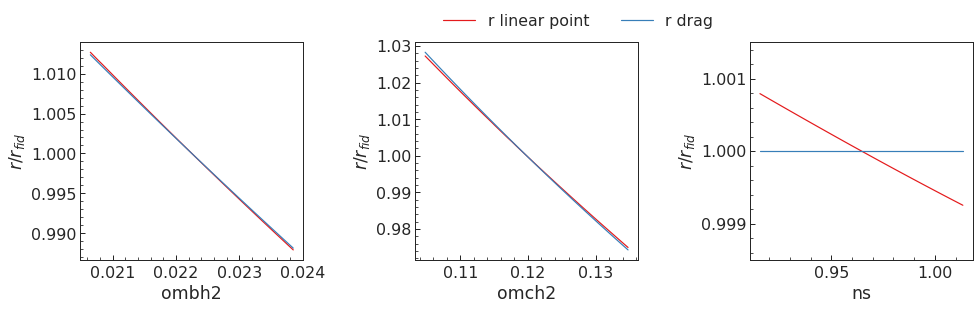

In [18]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(16,4), sharey=False)
axes = [ax1, ax2, ax3]

# plotting
for ax, df in zip(axes,dfs):
    ax.plot(df.iloc[:,0], df.loc[:,'lp']/lp_fid, label='r linear point')
    ax.plot(df.iloc[:,0], df.loc[:,'rd']/rd_fid, label='r drag')
    ax.set_xlabel(df.columns[0])
    ax.set_ylabel(r'$r/r_{fid}$')

# legend
ax1.legend(loc='best',ncol=2,frameon=False, bbox_to_anchor=(2.9, 1.2))

#
plt.subplots_adjust(wspace=0.5)

ax3.set_ylim(0.9985,1.0015)
ax3.set_yticks([0.999, 1.000, 1.001])


# plt.savefig('./Figures/lp_rd/r_over_r_fid_lp_and_rdrag.pdf', dpi=200,
#            bbox_inches='tight')
plt.show()

## Over large ranges

In [7]:
steps = 60

### Omch2

In [8]:
# getting values r = (80,210)
omch2_min = 0.01
omch2_max = 0.3
omch2_vals = np.linspace(omch2_min, omch2_max, steps)

In [32]:
#omch2
df_omch2 = pd.DataFrame(columns=['omch2','dip', 'peak', 'lp', 'rd'])

for i, omch2 in enumerate(omch2_vals):
    results = get_results(pars, omch2 = omch2)
    dip, peak = get_dip_peak(results,rmin=80, rmax=210)
    df_omch2.loc[i] = [omch2, dip, peak, (dip+peak)/2, get_rd(results)]

print("Done with omch2")

Done with omch2


In [33]:
df_omch2.to_pickle('./output/lp_rd/df_omch2_wide_v2.pkl')
df_omch2.to_csv('./output/lp_rd/df_omch2_wide_v2.csv', index=False)

#### Corr func

In [9]:
def gen_cbar(cmap, vmin, vmax, **kwargs):
    """Ref: https://stackoverflow.com/a/11558629"""
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin, vmax))
    sm._A = []
    plt.colorbar(sm, **kwargs)

In [10]:
# results cache
results_dict_omch2 = {}

In [17]:
# getting values r = (80,210)
omch2_min = 0.20
omch2_max = 0.50
omch2_step = 0.05

# steps = 7
# omch2_vals = np.linspace(omch2_min, omch2_max, steps)
omch2_vals = np.arange(omch2_min, omch2_max+omch2_step, omch2_step)
steps = len(omch2_vals)

# rlist
rmin = 50
rmax = 180
rsamples = 50
r_list = np.linspace(rmin, rmax, rsamples)

# colors
colors = sns.color_palette("plasma", steps)

0-1-2-3-4-5-6-

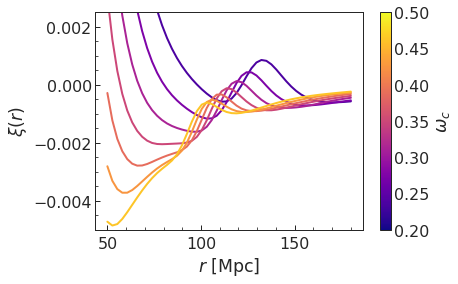

In [76]:
for i, omch2 in enumerate(omch2_vals):
    # get results using a cache
    if omch2 in results_dict_omch2:
        results = results_dict_omch2[omch2]
    else:
        results = get_results(pars, omch2 = omch2)
        results_dict_omch2[omch2] = results
    
    # calculate xi_list   
    pk = lp.get_pk_func(results, kmin, kmax, k_hunit=True)
    xi_list = [lp.xi(r*results.hubble_parameter(0)/100, pk) for r in r_list]
    plt.plot(r_list, xi_list, color = colors[i], lw=2)
    print(i, end="-")
    
plt.ylabel(r'$\xi(r)$')
plt.xlabel(r'$r$ [Mpc]')
plt.ylim(-0.005, 0.0025)


gen_cbar('plasma', omch2_min, omch2_max, label=r'$\omega_c$')

plt.savefig('./Figures/Summer 2019/xi_r_varying_omch2.pdf', dpi=200,
           bbox_inches='tight')

plt.show()

In [48]:

def xi_test(r, pk, a=1., n=4):
    """Two point correlation function for r.
    - pars
    r: float, correlation scale in real space
    pk: interp function object, power spectrum as function of k, P(k),
    limits of integration are given by this object through the x attribute 
    - returns
    xi(r): float, value of correlation func at r"""
    # sin is omitted in the integrand because its being weighted in quad
    def int_(k): return np.exp(-(k / a)**n) * \
        k**2 * pk(k) / (2 * (np.pi**2) * k * r)
    xir = quad(int_, pk.x[0]*(1+1e-8), pk.x[-1]*(1-1e-8), weight='sin', wvar=r)
    return xir[0]


In [40]:
results = results_dict_omch2[omch2_fid]
pk = lp.get_pk_func(results, kmin, kmax, k_hunit=False)
0.0015/lp.xi(110, pk)

3.073645569523697

0-

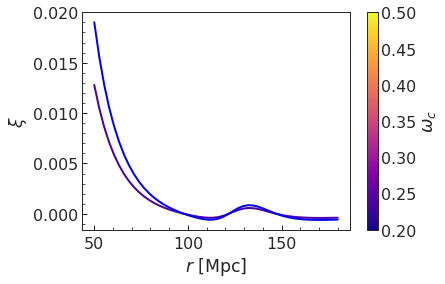

In [70]:
for i, omch2 in enumerate([omch2_vals[0]]):
    # get results using a cache
    if omch2 in results_dict_omch2:
        results = results_dict_omch2[omch2]
    else:
        results = get_results(pars, omch2 = omch2)
        results_dict_omch2[omch2] = results
    
    # calculate xi_list   
    pk = lp.get_pk_func(results, kmin, kmax, k_hunit=False)
    xi_list = [lp.xi(r, pk)/(h_fid**2) for r in r_list]
    plt.plot(r_list, xi_list, color = colors[i], lw=2)
    
    # calculate xi_list   
    pk = lp.get_pk_func(results, kmin, kmax, k_hunit=True)
    xi_list = [lp.xi(r*h_fid, pk) for r in r_list]
    plt.plot(r_list, xi_list, color = 'b', lw=2)
    print(i, end="-")
    
    
plt.ylabel(r'$\xi$')
plt.xlabel(r'$r$ [Mpc]')
#plt.xlim(left=110, right=180)
#plt.ylim(0,top=0.002)


gen_cbar('plasma', omch2_min, omch2_max, label=r'$\omega_c$')

# plt.savefig('./Figures/Summer 2019/xi_r_varying_omch2.pdf', dpi=200,
#            bbox_inches='tight')

plt.show()

#### Comparing dip peak for two methods

In [59]:
def get_dip_peak_test(results, h, rmin=115., rmax=160., rsamples=80, khmin = kmin, khmax=kmax):
    """Returns dip, peak by interpolating xi(r) over specified range"""
    r_list, xi_list = xi_test(results, h, rmin, rmax, rsamples, khmin, khmax)
    xi_interp = CubicSpline(r_list, xi_list, extrapolate=False)
    roots = xi_interp.derivative().roots(extrapolate=False)
    return roots[0], roots[1]

def xi_test(results, h, rmin=115., rmax=160., rsamples=30, khmin = kmin, khmax=kmax):
    """Returns xi(r) for r varying between rmin, rmax in rsamples steps"""

    # get interpolate xi_list
    r_list = np.linspace(rmin, rmax, rsamples)
    pk = lp.get_pk_func(results, khmin, khmax, k_hunit=True)
    xi_list = [lp.xi(r*h, pk) for r in r_list]
    return r_list, xi_list

In [62]:
for i, omch2 in enumerate(omch2_vals):
    # get results using a cache
    if omch2 in results_dict_omch2:
        results = results_dict_omch2[omch2]
    else:
        results = get_results(pars, omch2 = omch2)
        results_dict_omch2[omch2] = results
    
    print('My method:', get_dip_peak(results,rmin=80, rmax=210, rsamples= 300))
    print('Stefano\'s:', get_dip_peak_test(results, h_fid, rmin=80, rmax=210, rsamples= 300))

My method: (112.01628725829944, 132.82488690757677)
Stefano's: (111.97956279896731, 132.84722091661973)
My method: (104.07401304279017, 125.45991501855718)
Stefano's: (104.04112452006915, 125.49118255028709)
My method: (96.82665348790083, 119.38632502778434)
Stefano's: (96.80664384016768, 119.4277324649219)
My method: (114.2402861516203, 136.20603316762487)
Stefano's: (114.28925253539968, 136.21934130298666)
My method: (109.73362682733382, 128.49876103617635)
Stefano's: (109.78052466830894, 128.4208901023567)
My method: (105.83611658110063, 123.29324952098848)
Stefano's: (105.94423383827547, 123.30154012539525)
My method: (103.00511939628139, 118.3011491589048)
Stefano's: (103.09902521638564, 118.3485542253403)


#### Fixing omch2 and varying kmax

In [43]:
kmax_arr = np.array([5,10,20,30,50,100])
steps = len(kmax_arr)
omch2 = 0.5

# rlist
rmin = 50
rmax = 130
rsamples = 100
r_list = np.linspace(rmin, rmax, rsamples)
colors = sns.color_palette("viridis", steps)

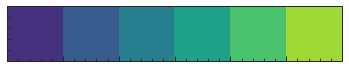

In [44]:
sns.palplot(colors)

In [45]:
# base result
kmax = 10
results = get_results(pars, omch2 = omch2, kmax=kmax)
pk = lp.get_pk_func(results, kmin, kmax, k_hunit=False)
xi_list_10 = np.array([lp.xi(r, pk,n=4, a=1) for r in r_list])

0-1-2-3-4-5-

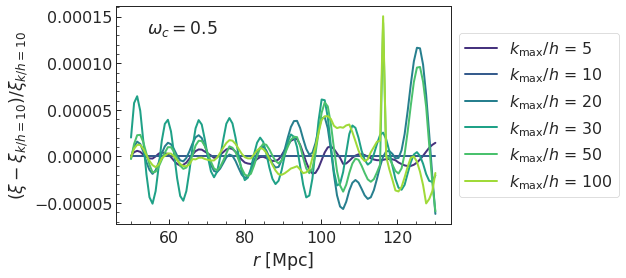

In [51]:
for i, kmax in enumerate(kmax_arr):
    # get results using a cache
    if kmax in results_dict_kmax:
        results = results_dict_kmax[kmax]
    else:
        results = get_results(pars, omch2 = omch2, kmax=kmax)
        results_dict_kmax[kmax] = results
    
    # calculate xi_list   
    pk = lp.get_pk_func(results, kmin, kmax, k_hunit=False)
    xi_list = np.array([lp.xi(r, pk,n=4, a=1) for r in r_list])
#     plt.plot(r_list, xi_list, color = colors[i], lw=1.5*len(colors)/(2*i+1))
    plt.plot(r_list, (xi_list - xi_list_10)/xi_list_10, color = colors[i], lw=2, 
             label=r'$k_{\rm max}/h$ = ' + str(kmax))
    print(i, end="-")
    
plt.ylabel(r'$(\xi - \xi_{k/h=10})/\xi_{k/h=10}$')
plt.xlabel(r'$r$ [Mpc]')
#plt.ylim(top=0.000)
ax = plt.gca()
plt.text(0.2,0.9, r'$\omega_c = $' + str(omch2), horizontalalignment='center',
verticalalignment='center', transform=ax.transAxes)

#gen_cbar('viridis', kmax_arr.min(), kmax_arr.max(), label=r'$k_{\rm max}/h$')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('./Figures/Summer 2019/xi_r_varying_kmax.pdf', dpi=200,
           bbox_inches='tight')

plt.show()

### Ombh2

In [34]:
ombh2_min = 0.005 # 150-190
ombh2_max = 0.196 # 65 - 140
ombh2_vals = np.linspace(ombh2_min, ombh2_max, steps)

In [35]:
# getting results
#ombh2
df_ombh2 = pd.DataFrame(columns=['ombh2','dip', 'peak', 'lp', 'rd'])

for i, ombh2 in enumerate(ombh2_vals):
    results = get_results(pars, ombh2 = ombh2)    
    dip, peak = get_dip_peak(results,rmin=65, rmax=190, rsamples = 120)
    df_ombh2.loc[i] = [ombh2, dip, peak, (dip+peak)/2, get_rd(results)]
    
print("Done with ombh2")

/home/marcio/miniconda3/envs/research/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


Done with ombh2


In [36]:
df_ombh2.to_pickle('./output/lp_rd/df_ombh2_wide_v2.pkl')
df_ombh2.to_csv('./output/lp_rd/df_ombh2_wide_v2.csv', index=False)

### ns

In [37]:
ns_min = 0.5025
ns_max = 2.0
ns_vals = np.linspace(0.5025, 2.0, steps)

In [38]:
#ns
df_ns = pd.DataFrame(columns=['ns','dip', 'peak', 'lp', 'rd'])

for i, ns in enumerate(ns_vals):
    results = get_results(pars, ns = ns)
    try:
        dip, peak = get_dip_peak(results,rmin=115, rmax=160)
        df_ns.loc[i] = [ns, dip, peak, (dip+peak)/2, get_rd(results)]
    except:
        print("Broke when ns={}".format(ns))
        df_ns.loc[i] = np.nan
    
print("Done with ns")

Done with ns


In [39]:
df_ns.to_pickle('./output/lp_rd/df_ns_wide_v2.pkl')
df_ns.to_csv('./output/lp_rd/df_ns_wide_v2.csv', index=False)

### Plotting - wide ranges

In [8]:
#df_ombh2 = pd.read_pickle('./output/lp_rd/df_ombh2_wide.pkl') - old upper limit
df_ombh2 = pd.read_pickle('./output/lp_rd/df_ombh2_wide_v2.pkl')
df_omch2 = pd.read_pickle('./output/lp_rd/df_omch2_wide_v2.pkl')
df_ns = pd.read_pickle('./output/lp_rd/df_ns_wide_v2.pkl')

In [9]:
dfs = [df_ombh2, df_omch2, df_ns]

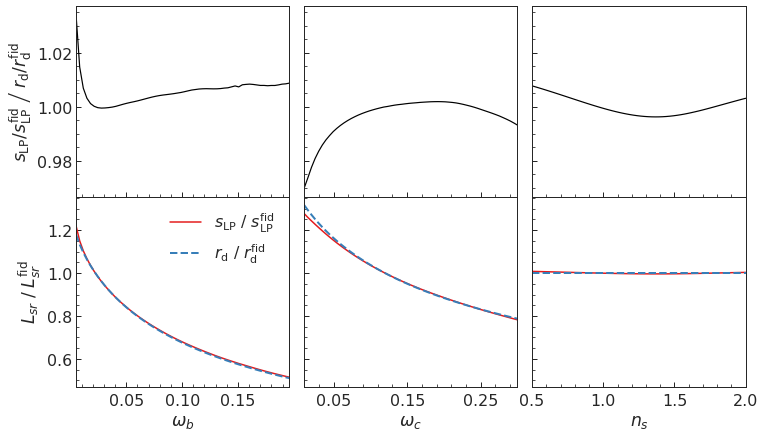

In [12]:
fig, axes = plt.subplots(2,3,figsize=(12,7), sharey='row', sharex='col')
factor = rd_fid/lp_fid
ax_labels = [   r'$\omega_b$',
                r'$\omega_c$',
                r'$n_s$']
# plot
for i, df in enumerate(dfs):
    ## ratio
    ax = axes[0][i]
    data_rat = (factor*df.loc[:,'lp']/df.loc[:,'rd']).to_frame()
    data_rat.index = df.iloc[:,0]
    #data_rat = data_rat.rolling(5,win_type='gaussian', center=True).mean(std=3)
    data_rat.plot(ax=ax, legend=False, color='k')
    #ax.set_xlabel(df.columns[0])
    ax.set_xlim(data_rat.dropna().index.min(),data_rat.dropna().index.max())
    
    ## curves
    ax = axes[1][i]
    ax.plot(df.iloc[:,0], df.loc[:,'lp']/lp_fid, lw=1.5,
            label = r'$s_{\rm LP}$ / $s^{\rm fid}_{\rm LP}$')
    ax.plot(df.iloc[:,0], df.loc[:,'rd']/rd_fid, '--', lw=2,
            label=r'$r_{\rm d}$ / $r^{\rm fid}_{\rm d}$')
    ax.set_xlabel(df.columns[0])
    ax.set_xlim(df.iloc[:,0].min(),df.iloc[:,0].max())
    
# label
for i in range(len(axes[1])):
    axes[1][i].set_xlabel(ax_labels[i])

axes[0][0].set_ylabel(r'$ \left. s_{\rm LP} / s^{\rm fid}_{\rm LP} \; \right/ \; r_{\rm d}/r^{\rm fid}_{\rm d}$')
axes[1][0].set_ylabel(r'$L_{sr} \; / \; L^{\rm fid}_{sr}$')

# legend
axes[1][0].legend(frameon=False)

# adjustments

axes[1][1].set_xticks([0.05,0.15,0.25])
#axes[1][0].set_xticks([0.01,0.04,0.07, 0.1])
plt.subplots_adjust(wspace=0.07, hspace=0.0)

plt.savefig('./Figures/Summer 2019/rlp_and_rdrag_joint_wide_v2.pdf', dpi=200,
           bbox_inches='tight')

plt.show()

### Plotting - narrow ranges

In [10]:
df_ombh2 = pd.read_pickle('./output/lp_rd/df_ombh2_accuracy150.pkl')
df_omch2 = pd.read_pickle('./output/lp_rd/df_omch2_accuracy150.pkl')
df_ns = pd.read_pickle('./output/lp_rd/df_ns_accuracy150.pkl')

In [11]:
dfs = [df_ombh2, df_omch2, df_ns]

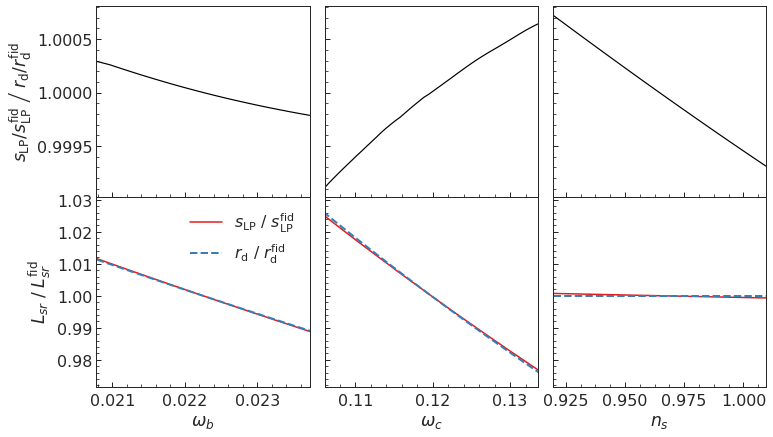

In [23]:
fig, axes = plt.subplots(2,3,figsize=(12,7), sharey='row', sharex='col')
factor = rd_fid/lp_fid
ax_labels = [   r'$\omega_b$',
                r'$\omega_c$',
                r'$n_s$']
# plot
for i, df in enumerate(dfs):
    ## ratio
    ax = axes[0][i]
    data_rat = (factor*df.loc[:,'lp']/df.loc[:,'rd']).to_frame()
    data_rat.index = df.iloc[:,0]
    data_rat = data_rat.rolling(5,win_type='gaussian', center=True).mean(std=3)
    data_rat.plot(ax=ax, legend=False, color='k')
    #ax.set_xlabel(df.columns[0])
    ax.set_xlim(data_rat.dropna().index.min(),data_rat.dropna().index.max())
    
    ## curves
    ax = axes[1][i]
    ax.plot(df.iloc[:,0], df.loc[:,'lp']/lp_fid, lw=1.5,
            label = r'$s_{\rm LP}$ / $s^{\rm fid}_{\rm LP}$')
    ax.plot(df.iloc[:,0], df.loc[:,'rd']/rd_fid, '--', lw=2,
            label=r'$r_{\rm d}$ / $r^{\rm fid}_{\rm d}$')
    ax.set_xlabel(df.columns[0])
    #ax.set_xlim(df.iloc[:,0].min(),df.iloc[:,0].max())
    
# label
for i in range(len(axes[1])):
    axes[1][i].set_xlabel(ax_labels[i])

axes[0][0].set_ylabel(r'$ \left. s_{\rm LP} / s^{\rm fid}_{\rm LP} \; \right/ \; r_{\rm d}/r^{\rm fid}_{\rm d}$')
axes[1][0].set_ylabel(r'$L_{sr} \; / \; L^{\rm fid}_{sr}$')

# legend
axes[1][0].legend(frameon=False)

# adjustments

#axes[1][1].set_xticks([0.05,0.15,0.25])
#axes[1][0].set_xticks([0.01,0.04,0.07, 0.1])
axes[0][0].set_yticks([-0.0005+1,1,0.0005+1])
axes[0][0].set_yticklabels(['0.9995','1.0000','1.0005'])
plt.subplots_adjust(wspace=0.07, hspace=0.0)

plt.savefig('./Figures/Summer 2019/rlp_and_rdrag_joint_10sig_range.pdf', dpi=200,
           bbox_inches='tight')

plt.show()